<a href="https://colab.research.google.com/github/natzasu13/microexpresion-recognition/blob/timeDistributed_SMIC/timeDistributedExample_KERAS_SMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

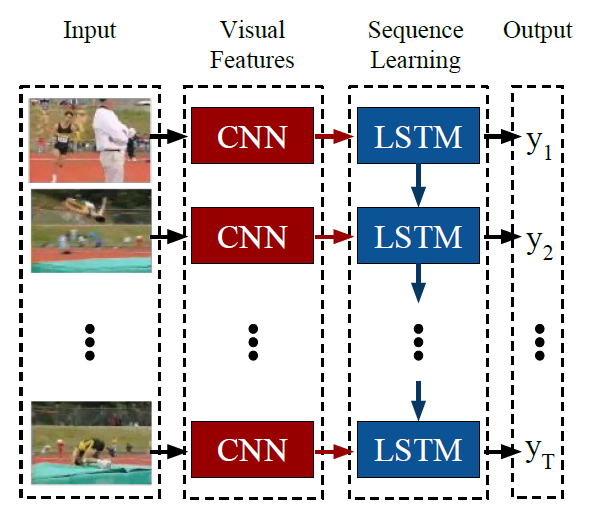

In [1]:
import keras
from keras.layers import Input ,Dense, Dropout, Activation, LSTM
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Reshape
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling1D
#from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Model

import numpy as np

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ruta = '/content/drive/MyDrive/TesisMScNataliaZartha/'
import numpy as np
from sklearn.model_selection import train_test_split

X = np.squeeze(np.load(ruta+'microexpstcnn_images_tr.npy'))
t = np.squeeze(np.load(ruta+'microexpstcnn_labels_tr.npy'))
X = np.moveaxis(X, -1, 1)


img = np.squeeze(X)/255.
lbl = t

X_train, X_val, y_train, y_val = train_test_split(img,lbl,test_size = 0.4,random_state = 123)

X_train = np.expand_dims(X_train,axis= 0)
X_train = np.moveaxis(X_train, 0, -1)

X_val = np.expand_dims(X_val,axis= 0)
X_val = np.moveaxis(X_val, 0, -1)


print(X_val.shape)

(64, 18, 64, 64, 1)


In [5]:
#%%
num_frames = 18
width = 64
height = 64
num_classes = 3


model = Sequential()

model.add(
    TimeDistributed(
        Convolution2D(64, (3, 3), activation='relu'), 
        input_shape=(num_frames, width, height, 1)
    )
)
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(1, 1))))

model.add(TimeDistributed(Convolution2D(128, (4,4), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(256, (4,4), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(326, (4,4), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# extract features and dropout 
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))

# input to LSTM
model.add(LSTM(256, return_sequences=False, dropout=0.5))

# classifier with sigmoid activation for multilabel
model.add(Dense(num_classes, activation='softmax'))
model.summary()
#%%


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 62, 62, 64)    640       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 61, 61, 64)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 58, 58, 128)   131200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 29, 29, 128)   0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 26, 26, 256)   524544    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 13, 13, 256)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 10, 10, 326)   1

In [6]:
from tensorflow import keras

In [7]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    #optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    ruta+"3d_image_classification_smic.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="acc", patience=25)

# Train the model, doing validation at the end of each epoch
epochs = 500
model.fit(X_train,y_train,
          validation_data=(X_val,y_val),
          epochs=epochs,
          shuffle=True,
          verbose=2,
          callbacks=[checkpoint_cb,early_stopping_cb],
          #callbacks=[checkpoint_cb],
)


Epoch 1/500
3/3 - 74s - loss: 1.0951 - acc: 0.4211 - val_loss: 1.0800 - val_acc: 0.4688
Epoch 2/500
3/3 - 4s - loss: 1.0789 - acc: 0.4105 - val_loss: 1.0745 - val_acc: 0.4688
Epoch 3/500
3/3 - 4s - loss: 1.0656 - acc: 0.4211 - val_loss: 1.0588 - val_acc: 0.4688
Epoch 4/500
3/3 - 4s - loss: 1.0624 - acc: 0.4105 - val_loss: 1.0482 - val_acc: 0.4688
Epoch 5/500
3/3 - 4s - loss: 1.0467 - acc: 0.4211 - val_loss: 1.0390 - val_acc: 0.4844
Epoch 6/500
3/3 - 4s - loss: 1.0450 - acc: 0.5158 - val_loss: 1.0401 - val_acc: 0.5938
Epoch 7/500
3/3 - 4s - loss: 1.0119 - acc: 0.6211 - val_loss: 0.9886 - val_acc: 0.5781
Epoch 8/500
3/3 - 4s - loss: 0.9741 - acc: 0.6421 - val_loss: 0.9283 - val_acc: 0.5781
Epoch 9/500
3/3 - 4s - loss: 0.9019 - acc: 0.6211 - val_loss: 0.8323 - val_acc: 0.5938
Epoch 10/500
3/3 - 4s - loss: 0.8251 - acc: 0.6000 - val_loss: 1.0461 - val_acc: 0.4688
Epoch 11/500
3/3 - 4s - loss: 0.9347 - acc: 0.6000 - val_loss: 0.9166 - val_acc: 0.6719
Epoch 12/500
3/3 - 4s - loss: 0.7524 - a

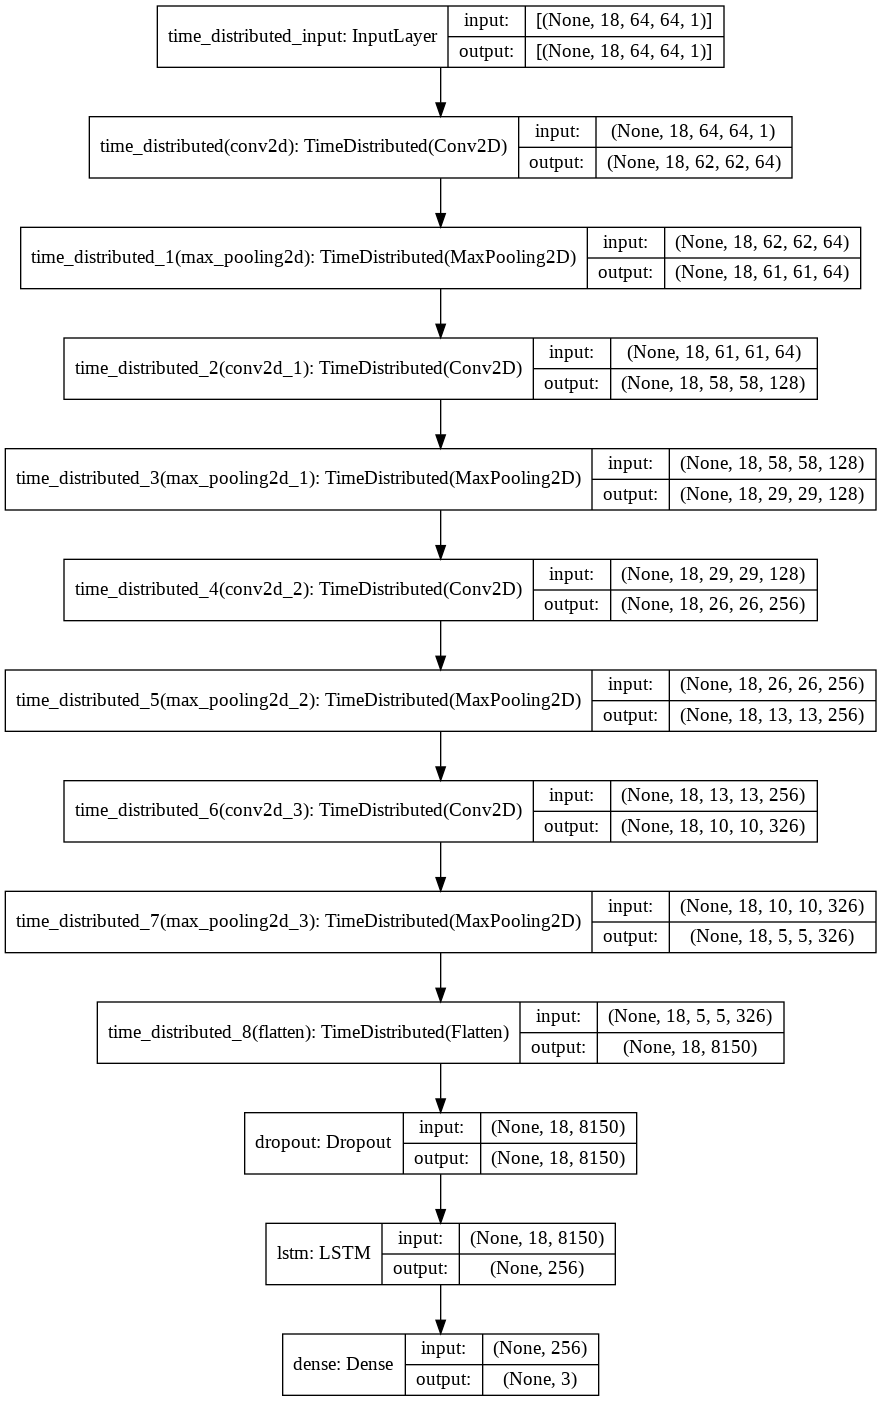

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


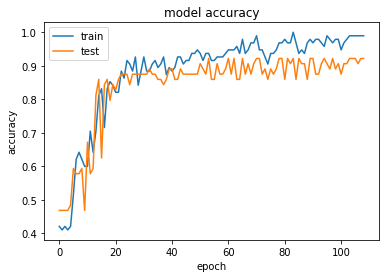

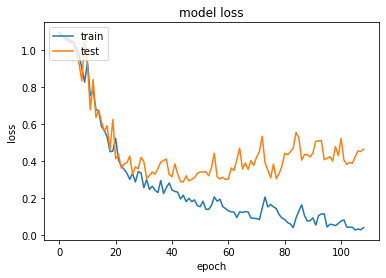

In [9]:
import matplotlib.pyplot as plt
history = model.history
# Trainig Process
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Evaluation

Acc Val: 0.921875
------------------------------return all metrics results------------------------------
--------------------------------------------------------------------------------------
accuracy (EXACTITUD) 0.921875
f1 score macro 0.9120260328239955
f1 score micro 0.921875
precision score (PRESICION) 0.9057539682539683
recall score (SENSIBILIDAD) 0.9222222222222222
hamming_loss 0.078125
classification_report               precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.81      0.87      0.84        15
           2       0.90      1.00      0.95        19

    accuracy                           0.92        64
   macro avg       0.91      0.92      0.91        64
weighted avg       0.93      0.92      0.92        64

jaccard_similarity_score 0.921875
zero_one_loss 0.078125
matthews_corrcoef 0.8814963105696756


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


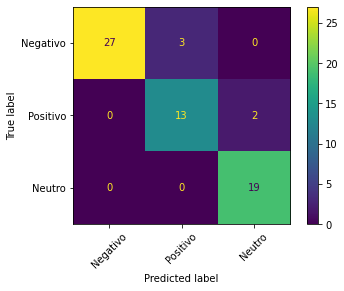

In [10]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score,ConfusionMatrixDisplay, recall_score, classification_report, hamming_loss, jaccard_similarity_score, log_loss, zero_one_loss, matthews_corrcoef


yEst_val = model.predict(X_val)

tEst_val = np.argmax(yEst_val,axis=1)
t_val = np.argmax(y_val,axis=1)

print('Acc Val:',accuracy_score(t_val,tEst_val))

cMat_val = confusion_matrix(t_val,tEst_val)

ax = ConfusionMatrixDisplay(cMat_val,display_labels=['Negativo','Positivo','Neutro'])
ax.plot(xticks_rotation = 45)


print("------------------------------return all metrics results------------------------------")
print("--------------------------------------------------------------------------------------")

def evaluation_analysis(true_label,predicted): 
    '''
    return all metrics results
    '''
    print("accuracy (EXACTITUD)",accuracy_score(true_label, predicted))
    print("f1 score macro",f1_score(true_label, predicted, average='macro'))     
    print("f1 score micro",f1_score(true_label, predicted, average='micro'))
    print("precision score (PRESICION)",precision_score(true_label, predicted, average='macro'))
    print("recall score (SENSIBILIDAD)",recall_score(true_label, predicted, average='macro'))
    print("hamming_loss",hamming_loss(true_label, predicted))
    print("classification_report", classification_report(true_label, predicted))
    print("jaccard_similarity_score", jaccard_similarity_score(true_label, predicted))
    #print("log_loss", log_loss(true_label, predicted))
    print("zero_one_loss", zero_one_loss(true_label, predicted))
    #print("AUC&ROC",roc_auc_score(true_label, predicted))
    print("matthews_corrcoef", matthews_corrcoef(true_label, predicted)) 




evaluation_analysis(t_val,tEst_val)

#ROC and Precision-Recall curves

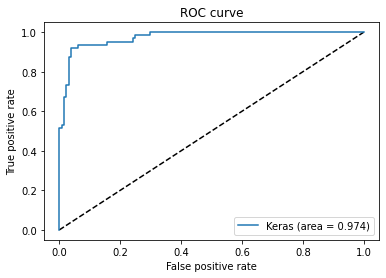

In [11]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, hamming_loss, jaccard_similarity_score, log_loss, zero_one_loss, matthews_corrcoef, confusion_matrix, accuracy_score, classification_report, precision_recall_curve, roc_curve, auc

#https://webmonkez.com/questions/1637057/como-encontrar-la-curva-roc-y-la-puntuacion-auc-del-modelo-cnn-keras

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val.ravel(), yEst_val.ravel())

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Save model as json string


In [12]:
import datetime
current_date = datetime.datetime.today().strftime("%Y-%m-%d_%H:%M:%S")

path = ruta + 'model/'
model.save(path +  'model_'+current_date) 


model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TesisMScNataliaZartha/model/model_2021-09-28_20:51:09/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TesisMScNataliaZartha/model/model_2021-09-28_20:51:09/assets
